# MultiSpectral_PCA_Compressor

## What do:

* Search for png files in all folder inside the user_defined folder and generate a list
* Search for the string ScientificLeft and ScientificRight in the filenames
* crop the image using the target ROI (needs to be done manually)
* For each side, read the images and store them into a dataframe
* For each dataframe, compute PCA with 3 components to generate a false
* Convert the 3-component PCA back to an image and save as png.


In [1]:
import os
import rasterio
from os import path
import numpy as np
import pandas as pd
import pathlib
import cv2 as cv
import matplotlib.pyplot as plt

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
def get_paths(PATH, ixt):
    import re
    import fnmatch
    # os.chdir(PATH)
    ext='*.'+ixt
    chkCase = re.compile(fnmatch.translate(ext), re.IGNORECASE)
    files = [PATH+'/'+f for f in os.listdir(PATH) if chkCase.match(f)]
    return(files)

def num_extract(string):    
    return [s for s in string if s.isdigit()]

In [3]:
def pcaCompressor(dataframe, shape, savename):
    try:
        dataframe.drop(['Shape'],axis=1, inplace=True)
        
    except Exception as e:
        pass
    pca=PCA(n_components=3)    
    pca_recovered = pca.inverse_transform(pca.fit_transform(dataframe))

    recovered = []
    for ii in range(3):
        img = pca_recovered[ii,:].reshape(shape[0],shape[1])
        
        recovered.append(cv.convertScaleAbs(img,alpha=(255.0/img.max())))
    img_reduced= (cv.merge((recovered[2],recovered[1],recovered[0])))       
    cv.imwrite(savename, cv.merge((recovered[2],recovered[1],recovered[0])))
    return img_reduced

In [4]:
def dataframe_creator(a,b,c,d, side, savedir):
    
    left_df = pd.DataFrame()
    right_df = pd.DataFrame()
    left_filters = []
    right_filters = []
    for image in image_lists:
        for i in image:
            # print(image[0])
            basedir = os.path.dirname(i)
            # print(basedir)
            basename = os.path.basename(i)
            # print(basedir+'/'+basename)

            path = pathlib.PurePath(basedir)
            if 'Scientific_Left' in path.name:
                # print(path.name)
                img = cv.imread(i)[a:b,c:d]
                gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                tmp_df = pd.DataFrame(gray.flatten().reshape(1,-1))
                tmp_df['Shape'] = [gray.shape]
                left_df = pd.concat([left_df,tmp_df])
                left_filters.append(num_extract(path.name.split('Left')[1])[0])
                #left_df.to_csv(savedir+'/multispectralcube_left.csv')
    
            if 'Scientific_Right' in path.name:
                # print(path.name)
                img = cv.imread(i)[a:b,c:d]
                gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                tmp_df = pd.DataFrame(gray.flatten().reshape(1,-1))
                tmp_df['Shape'] = [gray.shape]
                right_df = pd.concat([right_df,tmp_df])
                right_filters.append(num_extract(path.name.split('Right')[1])[0])
                #right_df.to_csv(savedir+'/multispectralcube_right.csv')
    if side in ['left']:
        return left_df,left_filters
    else:
        return right_df, right_filters

def cube_creator(dataframe):
    img_df = dataframe.drop(['Shape'], axis=1)
    result_img = []
    for ii in range(len(img_df)):
        shape = dataframe.iloc[ii]['Shape']
        result_img.append(img_df.iloc[ii].values.reshape(shape[0],shape[1]))        
    return np.stack(result_img, axis=2), shape

In [5]:
root_dir = './'
list_root = [dd for dd in os.listdir(root_dir) if os.path.isdir(dd)]

src_dir = './2022_04_04_13_20_39_one_stone'
last_dir = pathlib.Path(src_dir).name
new_dir = src_dir.split(last_dir)[0]+last_dir+'_processed'
os.makedirs(new_dir, exist_ok=True)
sub_dir = os.listdir(src_dir)

image_lists = []
for sdir in sub_dir:    
    fpath = src_dir+'/'+sdir    
    if path.isdir(fpath):
        image_lists.append(get_paths(fpath, 'png'))

In [6]:
#left_df,left_filters = dataframe_creator(210,310,680,900, 'left', new_dir)
#right_df, right_filters = dataframe_creator(210,300,450,650, 'right',new_dir) #2022_04_04_14_11_59

#left_df,left_filters = dataframe_creator(335,450,540,800, 'left', new_dir)
#right_df, right_filters = dataframe_creator(325,440,250,525, 'right', new_dir) #2022_04_04_14_02_20

left_df,left_filters = dataframe_creator(625,800,800,1150, 'left', new_dir) #2022_04_04_13_20_39_one_stone
right_df, right_filters = dataframe_creator(600,775,350,725, 'right', new_dir) #2022_04_04_13_20_39_one_stone



left_cube, left_shape = cube_creator(left_df)
righ_cube, right_shape = cube_creator(right_df)
save = new_dir+'/PCA_compressed_left.png'
reduce_left = pcaCompressor(left_df, left_shape, save)
save = new_dir+'/PCA_compressed_right.png'
reduce_right = pcaCompressor(right_df, right_shape, save)

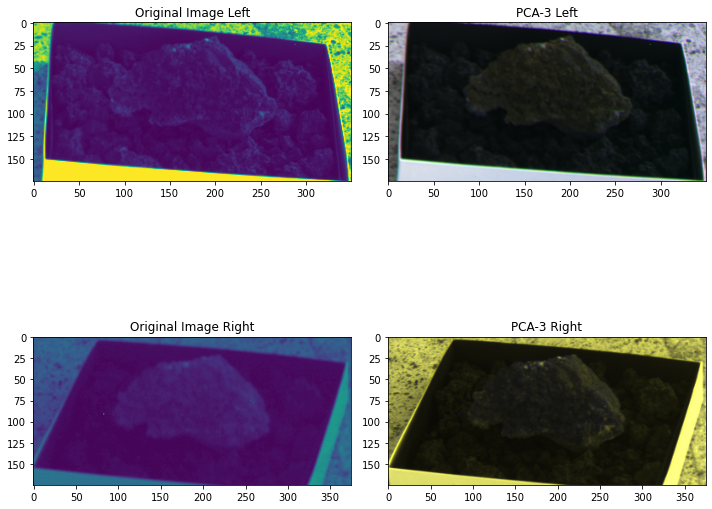

In [7]:
fig = plt.figure(figsize = (10, 10)) 
fig.add_subplot(221)
plt.title("Original Image Left")
plt.imshow(left_df.iloc[0].values.reshape(left_shape[0],left_shape[1]))
fig.add_subplot(222)
plt.title("PCA-3 Left")
plt.imshow(reduce_left)
fig.add_subplot(223)
plt.title("Original Image Right")
plt.imshow(right_df.iloc[0].values.reshape(right_shape[0],right_shape[1]))
fig.add_subplot(224)
plt.title("PCA-3 Right")
plt.imshow(reduce_right)
plt.tight_layout()
plt.show()

## Components check LEFT

In [8]:
try:
    dataframe.drop(['Shape'],axis=1, inplace=True)

except Exception as e:
    pass
pca=PCA(n_components=len(left_df))
pca_ = pca.fit_transform(left_df)

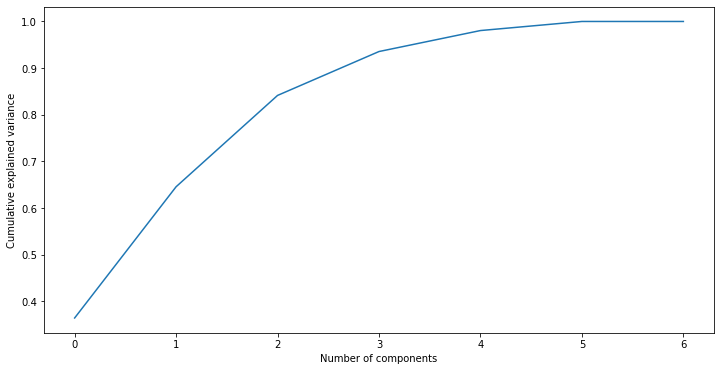

In [9]:
ev=pca.explained_variance_ratio_
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

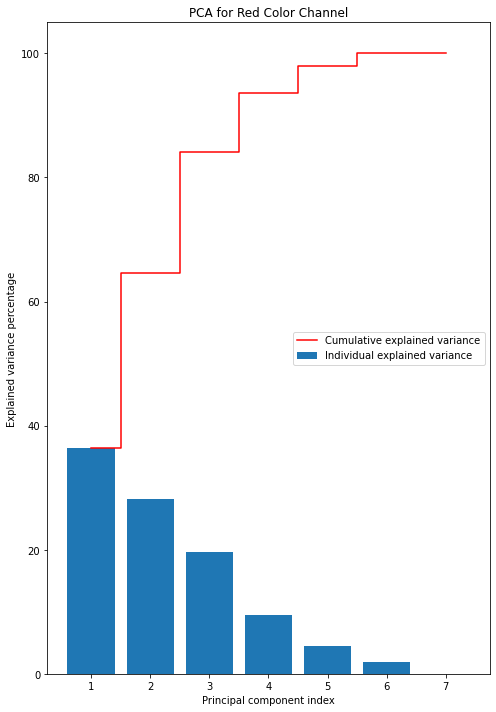

In [10]:
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.figure(figsize=[7, 10])

plt.bar(range(1, len(left_df)+1), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, len(left_df)+1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.legend(loc='right')
plt.title("PCA for Red Color Channel")
plt.tight_layout()


In [11]:
## Components check RIGHT

In [12]:
try:
    dataframe.drop(['Shape'],axis=1, inplace=True)

except Exception as e:
    pass
pca=PCA(n_components=len(right_df))
pca_ = pca.fit_transform(right_df)

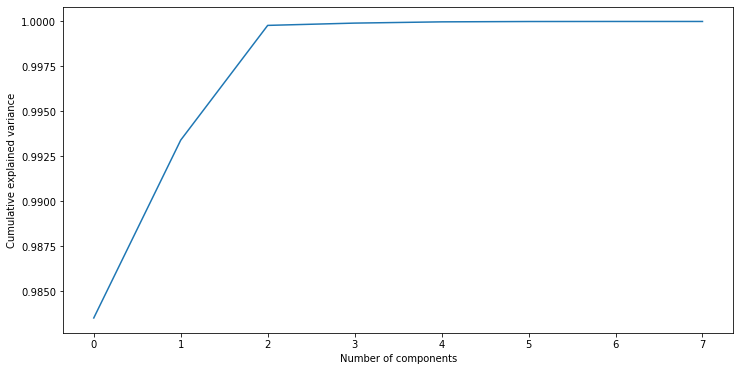

In [13]:
ev=pca.explained_variance_ratio_
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

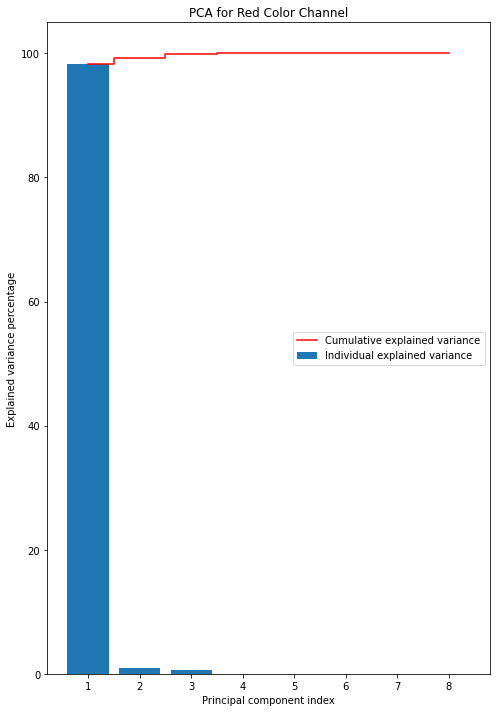

In [14]:
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.figure(figsize=[7, 10])

plt.bar(range(1, len(right_df)+1), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, len(right_df)+1), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.legend(loc='right')
plt.title("PCA for Red Color Channel")
plt.tight_layout()
